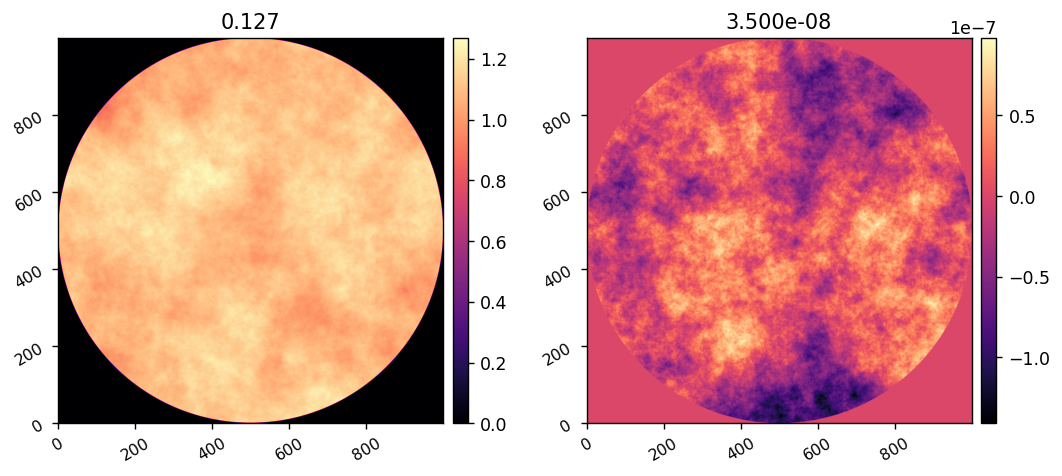

In [57]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from importlib import reload

from scipy.optimize import minimize

import scoobpsf
import scoobpsf.scoobi as scoobi
import scoobpsf.ad_scoob as ad_scoob
import scoobpsf.ad_efc as ad_efc
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

import purepyindi
from purepyindi import INDIClient
client0 = INDIClient('localhost', 7624)
client0.start()

import purepyindi2
from purepyindi2 import IndiClient
client = IndiClient()
client.connect()
client.get_properties()

WFE, mask = utils.generate_wfe(diam=10*u.mm,
                                npix=1000, oversample=1,
                                wavelength=650*u.nm,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*650e-9/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')


In [4]:
reload(scoobi)
xc, yc = (4263, 2920)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [6]:
reload(scoobi)
tbi = scoobi.SCOOBI(cam_channel='scicam', dm_channel='dm00disp05')

# Do the normalization

In [10]:
scoobi.move_psf(-20, 0, client0)

In [12]:
reload(scoobi)
tbi.set_zwo_exp_time(0.00001, client0)

Set the ZWO exposure time to 3.20e-05s


In [13]:
reload(scoobi)
tbi.set_zwo_emgain(1, client0)

Set the ZWO gain setting to 1.0


In [14]:
reload(scoobi)
tbi.set_fib_atten(10, client)

Set the fiber attenuation to 10.0


INFO:utils:Got semaphore index 1.


29542.92


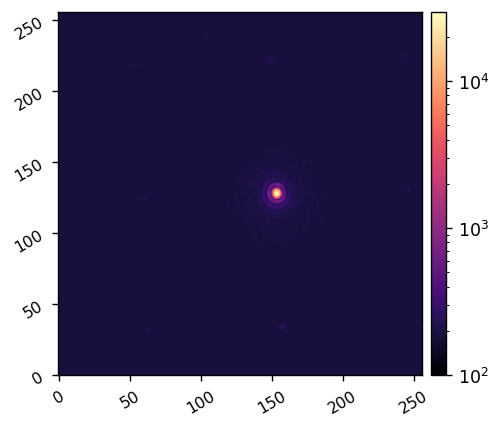

In [16]:
tbi.Nframes = 100
ref_psf = tbi.snap()
print(xp.max(ref_psf))
imshow1(ref_psf, lognorm=True, vmin=1e2)

In [39]:
reload(scoobi)
tbi = scoobi.SCOOBI(cam_channel='scicam', dm_channel='dm00disp05')
tbi.npsf = 150

tbi.Imax_ref = copy.copy(xp.max(ref_psf))
tbi.texp_ref = 3.2e-5
tbi.att_ref = 10
tbi.gain_ref = 1
print(tbi.Imax_ref, tbi.texp_ref, tbi.att_ref, tbi.gain_ref  )

29542.92 3.2e-05 10 1


In [29]:
scoobi.move_psf(-1, 0, client0)

In [32]:
scoobi.move_psf(0, -1, client0)

In [21]:
tbi.set_fib_atten(0, client)

Set the fiber attenuation to 0.0


In [40]:
tbi.set_zwo_exp_time(0.002, client0)

Set the ZWO exposure time to 2.00e-03s


In [41]:
tbi.set_zwo_emgain(120, client0)

Set the ZWO gain setting to 120.0


In [38]:
reload(scoobi)
scoobi.move_block_in(client0)

In [46]:
reload(scoobi)
scoobi.move_block_out(client0)

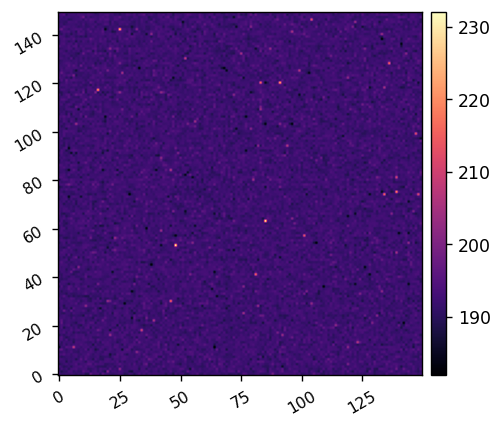

In [45]:
tbi.Nframes = 100
tbi.subtract_dark = False
tbi.return_ni = False
dark_frame = tbi.snap()
imshow1(dark_frame)

tbi.df = copy.copy(dark_frame)

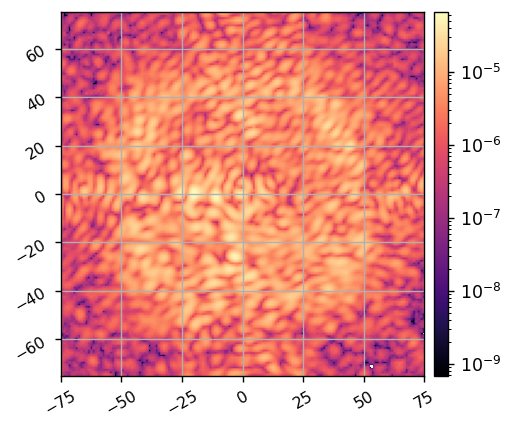

In [87]:
tbi.Nframes = 10
tbi.x_shift = -6
tbi.y_shift = -1

tbi.subtract_dark = True
tbi.return_ni = True

coro_im = tbi.snap()
imshow1(coro_im, lognorm=True, pxscl=1, grid=True)

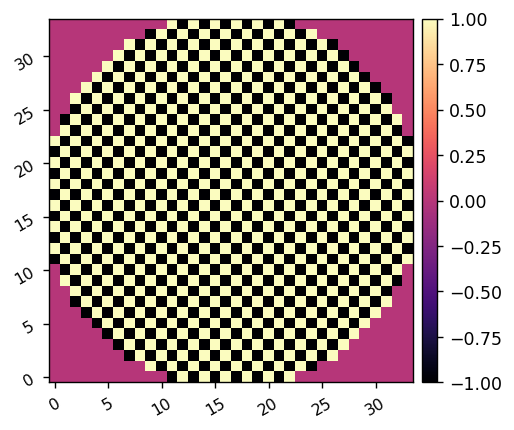

In [51]:
def create_sin_command(x_cpa=10, y_cpa=10, Nact=34):
    # cpa = cycles per aperture
    # max cpa must be Nact/2
    if x_cpa>Nact/2 or y_cpa>Nact/2:
        raise ValueError('The cycles per aperture is too high for the specified number of actuators.')
    y,x = xp.indices((Nact, Nact)) - Nact//2
    sin_command = xp.cos(2*np.pi*(x_cpa*x + y_cpa*y)/Nact)
    return sin_command

waffle_command = create_sin_command(x_cpa=17, y_cpa=17) * xp.array(tbi.dm_mask)
imshow1(waffle_command)

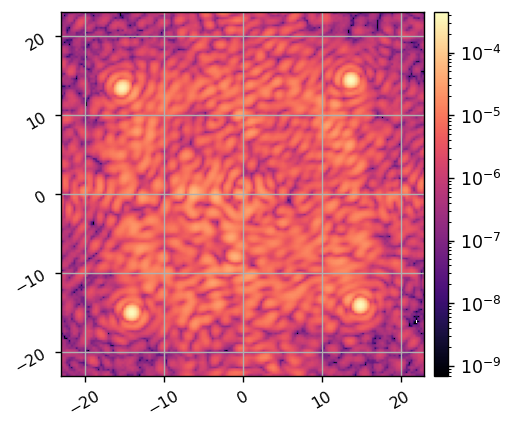

In [69]:
tbi.set_dm(15e-9 * waffle_command)
tbi.x_shift = -6
tbi.y_shift = -1

tbi.subtract_dark = True
tbi.return_ni = True
waffle_im = tbi.snap()
imshow1(waffle_im, lognorm=True, pxscl=tbi.psf_pixelscale_lamD, grid=True)

In [108]:
tbi.psf_pixelscale_lamD, m.psf_pixelscale_lamD

(0.307, 0.307)

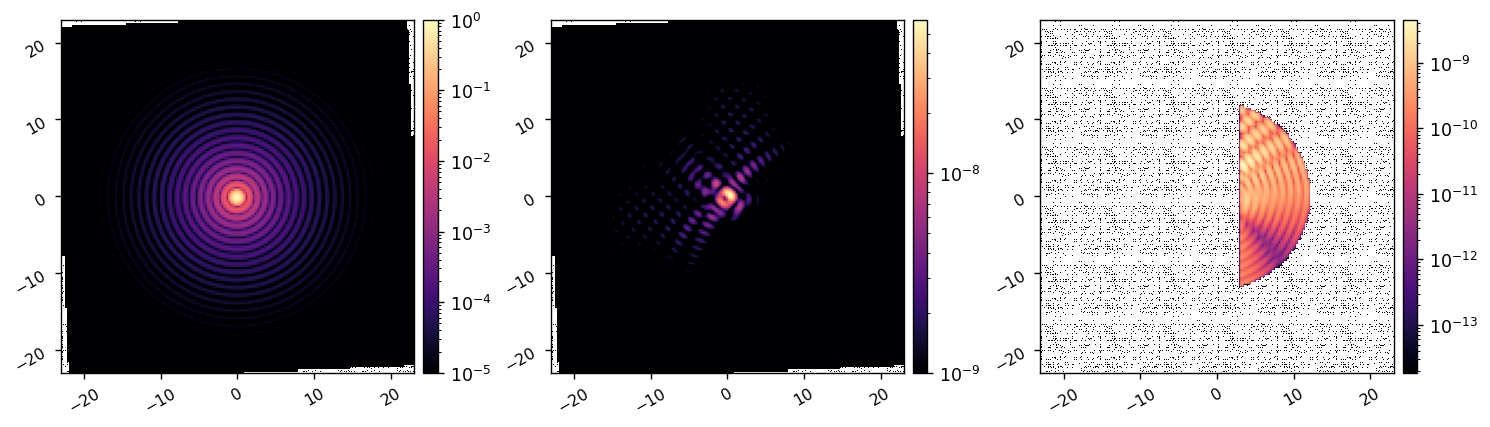

In [107]:
reload(ad_scoob)
m = ad_scoob.MODEL()
# m.WFE = WFE

m.npsf = 150
m.det_rotation = 177.5
m.psf_pixelscale_lamD = 0.307

m.create_control_mask()

acts = np.zeros(m.Nacts)

ref_psf = m.snap(acts, use_vortex=False)
m.Imax_ref = xp.max(ref_psf)
ref_coro_im = m.snap(acts)

imshow3(ref_psf/m.Imax_ref, ref_coro_im, ref_coro_im*m.control_mask,
        pxscl=m.psf_pixelscale_lamD, lognorm=True, vmin1=1e-5, vmin2=1e-9)


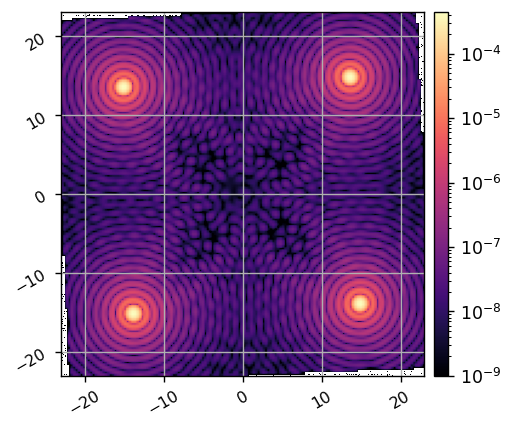

In [77]:
waffle_im_m = m.snap(15e-9 * waffle_command[m.dm_mask])
waffle_im_m *= xp.max(waffle_im)/xp.max(waffle_im_m)
imshow1(waffle_im_m, lognorm=True, pxscl=m.psf_pixelscale_lamD, grid=True, vmin=1e-9)

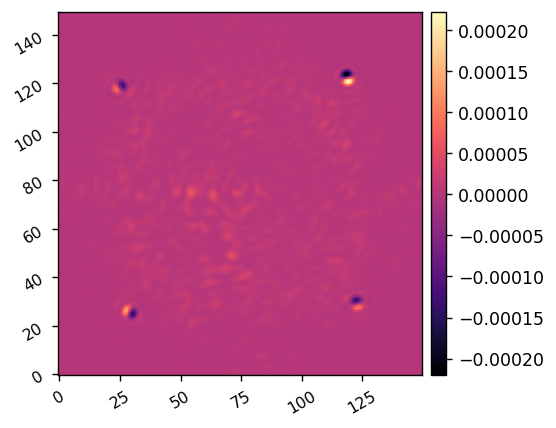

In [78]:

imshow1(waffle_im - waffle_im_m)

# Test PWP

In [110]:
def create_control_mask(npsf, pxscl, iwa=3, owa=12, edge=None, rotation=0, centered=True):
    x = (xp.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*pxscl
    x,y = xp.meshgrid(x,x)
    r = xp.hypot(x, y)
    control_mask = (r < owa) * (r > iwa)
    if edge is not None: control_mask *= (x > edge)

    control_mask = _scipy.ndimage.rotate(control_mask, rotation, reshape=False, order=0)
    return control_mask

control_mask = create_control_mask(tbi.npsf, tbi.psf_pixelscale_lamD, iwa=3, owa=12, edge=3,)

5.206264620440039e-06


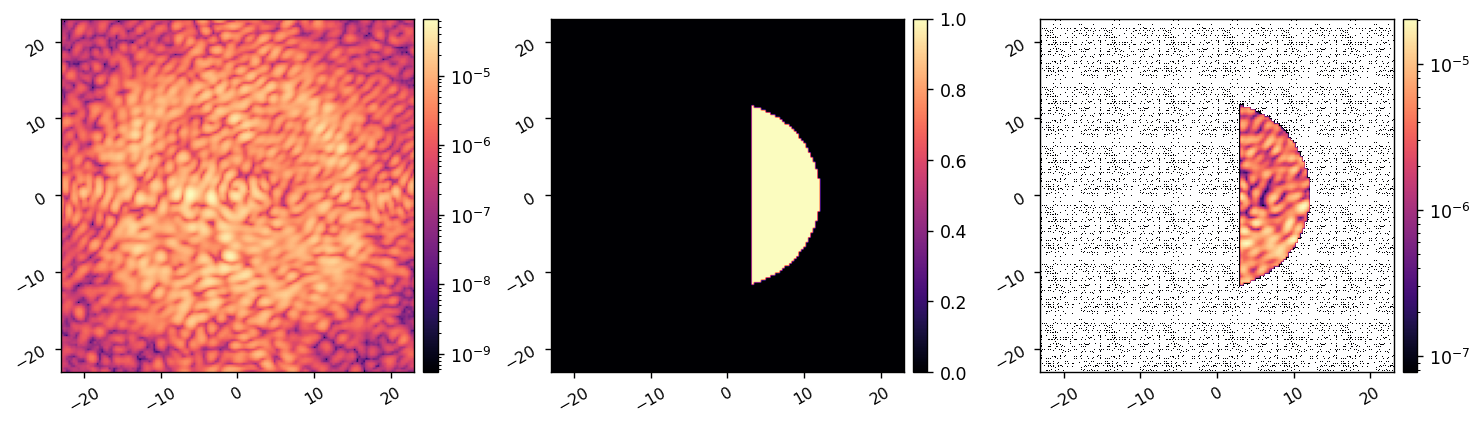

In [112]:
tbi.zero_dm()
tbi.Nframes = 10
tbi.subtract_dark = True
tbi.return_ni = True

ref_coro_im = tbi.snap()
print(xp.mean(ref_coro_im[control_mask]))
imshow3(ref_coro_im, control_mask, control_mask * ref_coro_im,
        lognorm1=True, lognorm3=True, pxscl=tbi.psf_pixelscale_lamD)

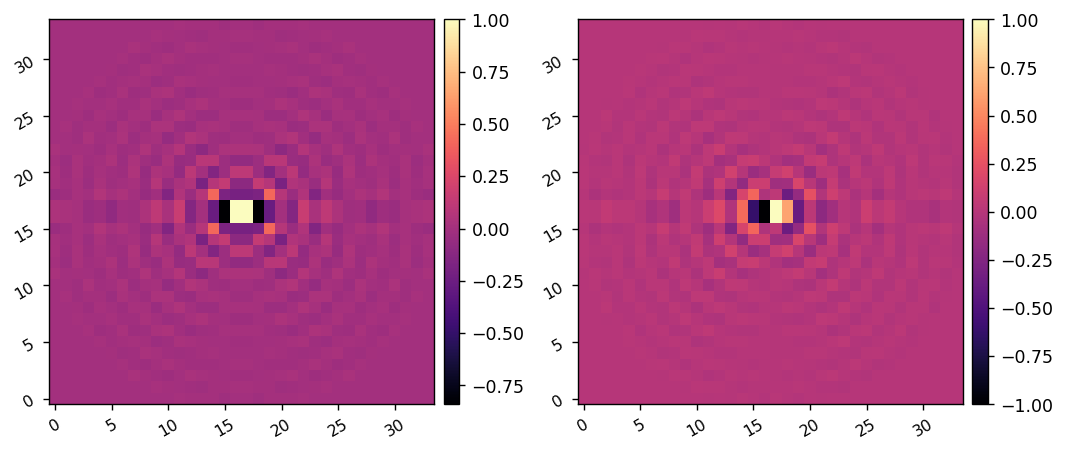

In [113]:
import lina 
reload(lina.utils)

probe_modes = lina.utils.create_fourier_probes(tbi, control_mask, fourier_sampling=0.25, 
                                            #    shift=[(0,8), (0,-8)], 
                                            #    shift=[(-8,0), (8,0)], 
                                            #    shift=[(-5,6), (5,6), (0, -5)], 
                                               use_weighting=True,
                                               nprobes=2, 
                                               )
imshow2(probe_modes[0], probe_modes[1])

In [102]:
tbi.set_zwo_emgain(120, client0)
tbi.set_zwo_exp_time(0.005, client0)

Set the ZWO gain setting to 120.0
Set the ZWO exposure time to 5.00e-03s


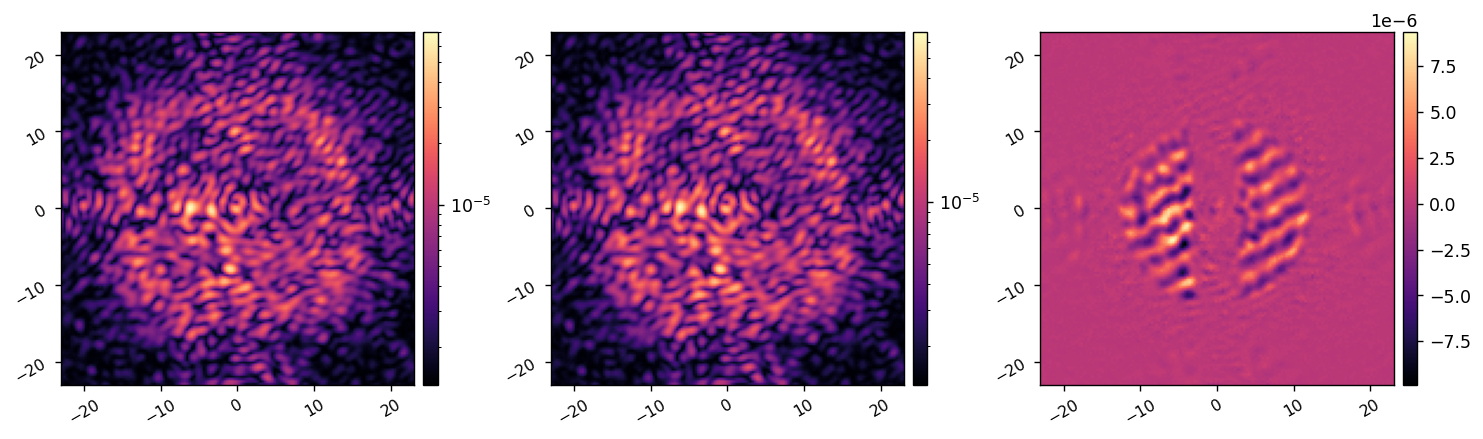

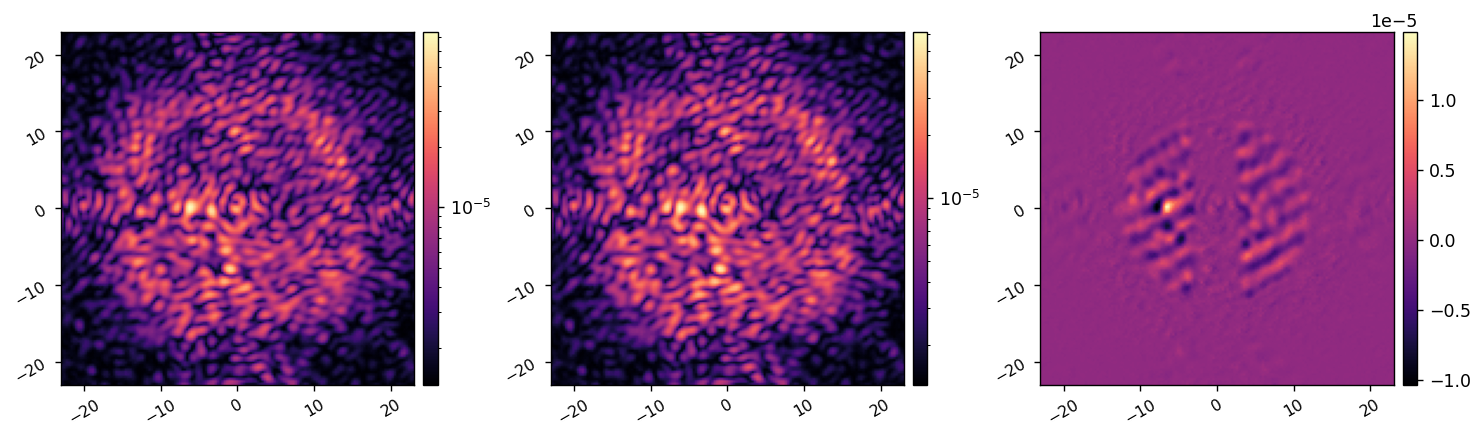

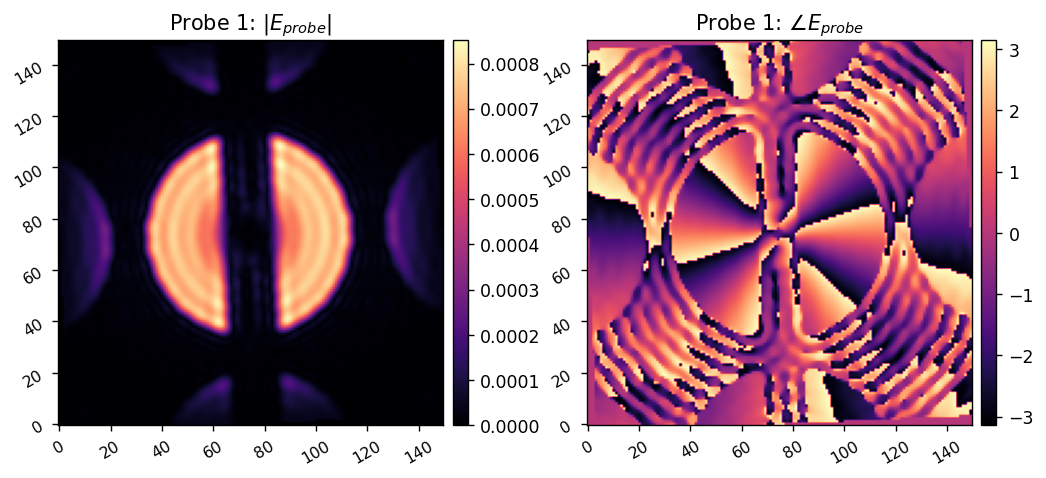

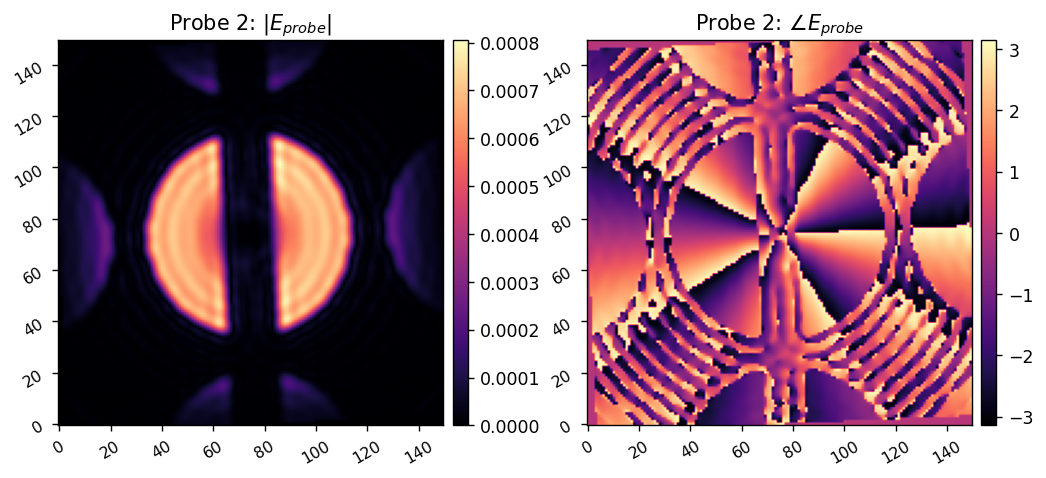

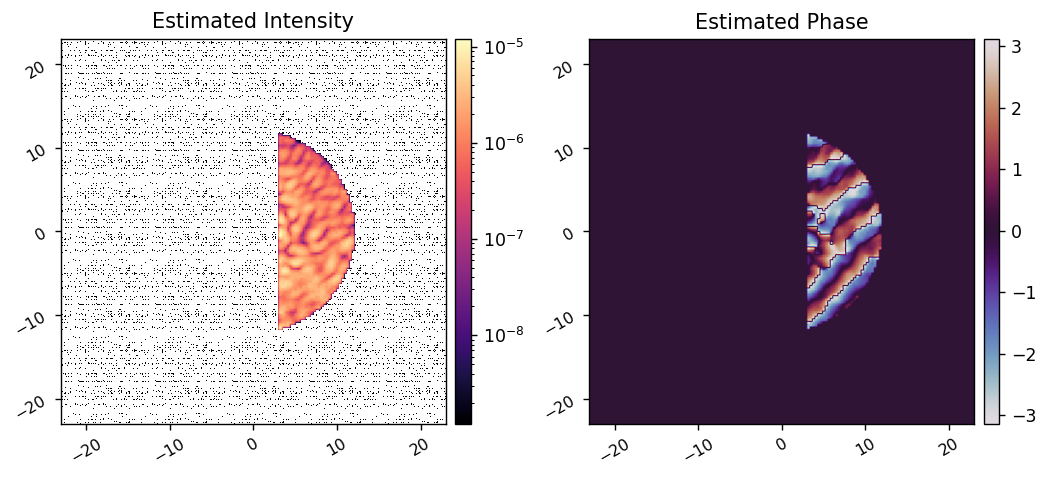

In [114]:
reload(ad_efc)

acts = xp.zeros(m.Nacts)
probe_amp = 5e-9

tbi.dm_delay = 0.25
tbi.subtract_dark = False
E_est = ad_efc.run_pwp(tbi, m, acts, 
                       control_mask, 
                       probe_modes, probe_amp, 
                       reg_cond=1e-3, 
                       plot=True,
                       plot_est=True,
                       )
I_est = xp.abs(E_est)**2
P_est = xp.angle(E_est)


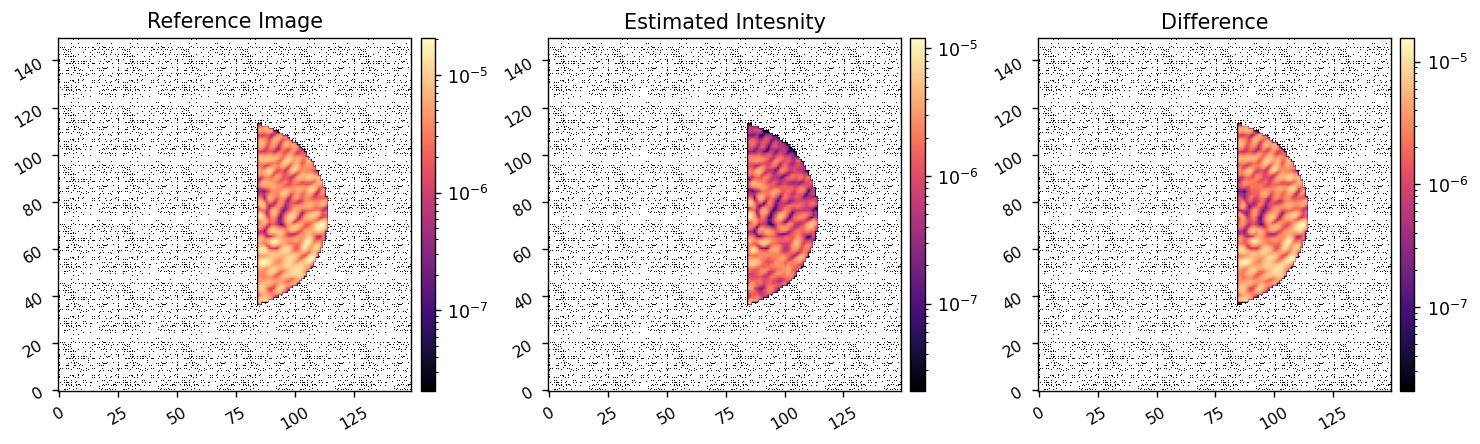

In [115]:
I = ref_coro_im*control_mask
I_diff = I - I_est
vmin = xp.max(I)/1e3
imshow3(I, I_est, xp.abs(I_diff), 
        'Reference Image', 'Estimated Intesnity', 'Difference',
        lognorm1=True, lognorm2=True, vmin1=vmin, vmin2=vmin, 
        lognorm3=True, vmin3=vmin,
        )

In [116]:
m.control_mask.sum(), control_mask.sum()

(array(1626), array(1626))

0.0025461857511820275 0.0 0.0025461857511820275 1.0


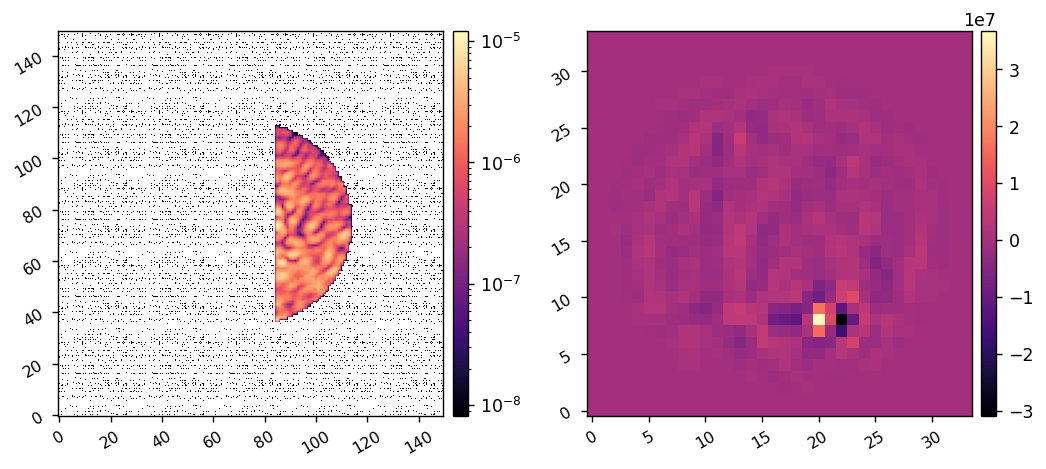

In [118]:
reload(ad_scoob)

acts = np.zeros(m.Nacts)
# acts = fits.getdata('data/ad_test_acts.fits')

E_ab = copy.copy(E_est)
r_cond = 1e-2

del_acts = np.zeros(m.Nacts)
J, dJ_dA = ad_scoob.val_and_grad(del_acts, m, acts, E_ab, r_cond, dead_acts=None, verbose=True)

dm_grad = ad_scoob.acts_to_command(dJ_dA, m.dm_mask)
imshow2(xp.abs(E_ab)**2, dm_grad, lognorm1=True)

In [119]:

acts = np.zeros(m.Nacts)
# acts = fits.getdata('data/ad_test_acts.fits')

E_ab = copy.copy(E_est)
r_cond = 1e-3
bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(m.Nacts)
res = minimize(ad_scoob.val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(m, acts, E_ab, r_cond, None, True), 
                method='L-BFGS-B',
                tol=bfgs_tol,
                options=bfgs_opts,
                )

0.0025461857511820275 0.0 0.0025461857511820275 1.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  3.66438D+07


 This problem is unconstrained.


0.004220600842035504 2495701154.7609243 0.0025461857511820275 980172461340.0864
0.4560381385972902 0.45106548825707327 0.0025461857511820275 356.25980014743806
2.3889144286039854 0.013847531669467047 0.0025461857511820275 943.6711202857085
0.17626692063287858 0.00013672438352543967 0.0025461857511820275 69.28153020042286
0.0010404724404229854 1.7805017486910547e-06 0.0025461857511820275 0.4093389265444701

At iterate    1    f=  4.09339D-01    |proj g|=  1.13802D+07
0.00041805150998159375 1.2247732823716499e-06 0.0025461857511820275 0.16466838017191907

At iterate    2    f=  1.64668D-01    |proj g|=  2.07651D+06
0.0003512823698426652 1.3224491640780296e-06 0.0025461857511820275 0.13848354105471367

At iterate    3    f=  1.38484D-01    |proj g|=  1.75934D+06
0.00030523702676898035 1.6369997031227554e-06 0.0025461857511820275 0.12052303188392346

At iterate    4    f=  1.20523D-01    |proj g|=  9.77036D+05
0.0002911939666295623 1.8358385150558027e-06 0.0025461857511820275 0.11508579254

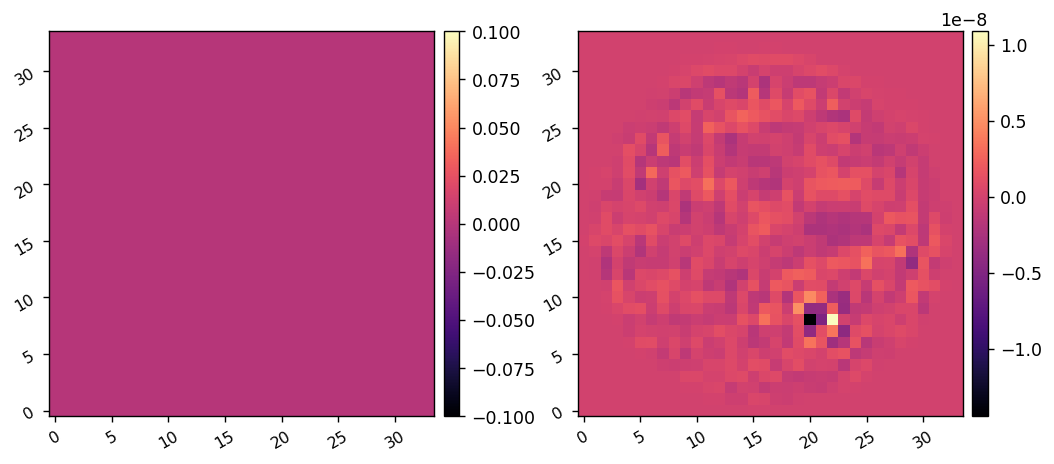

In [120]:
old_command = ad_scoob.acts_to_command(acts, m.dm_mask)
del_command = ad_scoob.acts_to_command(res.x, m.dm_mask)
imshow2(old_command, del_command)


6.480132512972448e-06 6.986283019048305e-06


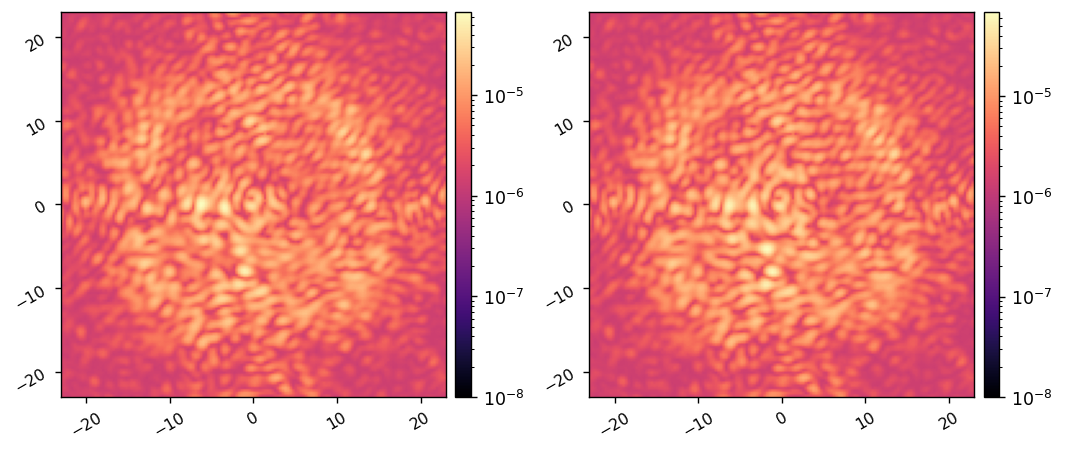

In [124]:

tbi.set_dm(old_command)
old_im = tbi.snap()
tbi.add_dm(del_command)
new_im = tbi.snap()

print(xp.mean(old_im[m.control_mask]), xp.mean(new_im[m.control_mask]))
imshow2(old_im, new_im, lognorm=True, pxscl=tbi.psf_pixelscale_lamD, vmin1=1e-8, vmin2=1e-8)